In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
#from pmdarima import auto_arima
import seaborn as sns
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings("ignore")



In [2]:
#Let’s take a sneak peek at the data.
df0 =  pd.read_pickle('input_monthly.pkl')
df0.index.freq = 'MS'
df0.tail(5)

,Labor Demand,Orders_millions_Q,Severance_Amount_millions_Q,Profit_margin_perc_Q,wage_max,Labor_conv_count_M,awh_prd_emp_mfg_dur_gds_cal_M_Fred,Civ_lab_force_SA_county_m_Fred,All_emp_mfg_dur_gds_SA_MSA_M_Fred
DATE,,,,,,,,,
2020-06-01,96,3040.0,5.0,7.1,23.49,0,25.595351,709583.0,21.5
2020-07-01,91,2080.0,5.0,9.9,23.49,4,25.378577,708988.0,21.3
2020-08-01,95,2080.0,5.0,9.9,23.49,8,25.396480,699501.0,21.6
2020-09-01,84,2080.0,5.0,9.9,23.49,3,25.263756,703712.0,21.6
2020-10-01,78,NaN,NaN,NaN,23.76,0,NaN,NaN,NaN


In [3]:
df = pd.DataFrame()
df['data'] = df0.All_emp_mfg_dur_gds_SA_MSA_M_Fred
df0 = df['2015-01-01': ] #  based on data availability
df0.data.tail()

DATE
2020-06-01    21.5
2020-07-01    21.3
2020-08-01    21.6
2020-09-01    21.6
2020-10-01     NaN
Freq: MS, Name: data, dtype: float64

In [4]:
df = df.fillna(method='bfill')
df = df.dropna(axis='rows')
df

,data
DATE,
2015-01-01,24.4
2015-02-01,24.4
2015-03-01,24.5
2015-04-01,24.7
2015-05-01,24.8
...,...
2020-05-01,21.6
2020-06-01,21.5
2020-07-01,21.3


In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#Define the time-series evaluation function, as shown here:
def get_rmse(y, y_hat):
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):

    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

In [6]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()
    
    #plotting rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show()
    
    #Dickey_Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)
    
    if dfoutput[1] <= 0.05:
        print("Data is stationary - and we need no transformation to make it stationary")
    else:
        print(" Data is not stationary and we will need to transform the series to make it stationary ")
    

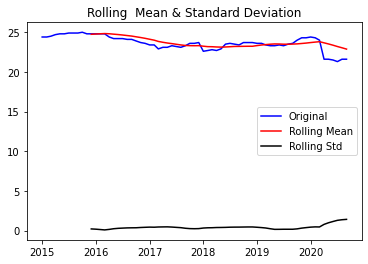

Results of Dickey-Fuller Test:
Test Statistic                 -1.001168
p-value                         0.752838
#Lags Used                      0.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64
 Data is not stationary and we will need to transform the series to make it stationary 


In [7]:
test_stationarity(df['data'])

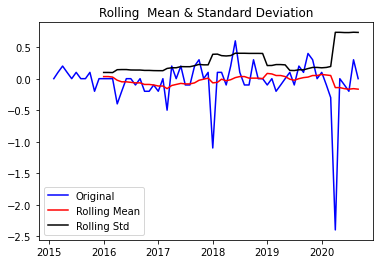

Results of Dickey-Fuller Test:
Test Statistic                -7.395934e+00
p-value                        7.778425e-11
#Lags Used                     0.000000e+00
Number of Observations Used    6.700000e+01
Critical Value (1%)           -3.531955e+00
Critical Value (5%)           -2.905755e+00
Critical Value (10%)          -2.590357e+00
dtype: float64
Data is stationary - and we need no transformation to make it stationary


In [8]:
df['data_diff1'] = ((df.data) - (df.data.shift(1))).dropna()
test_stationarity(df['data_diff1'][1:])

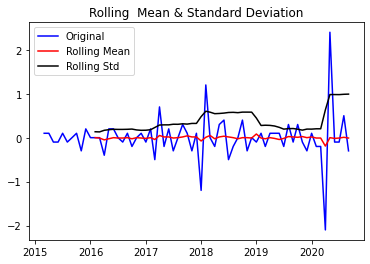

Results of Dickey-Fuller Test:
Test Statistic                -9.138645e+00
p-value                        2.889360e-15
#Lags Used                     1.000000e+00
Number of Observations Used    6.500000e+01
Critical Value (1%)           -3.535217e+00
Critical Value (5%)           -2.907154e+00
Critical Value (10%)          -2.591103e+00
dtype: float64
Data is stationary - and we need no transformation to make it stationary


In [9]:
df['data_diff2_1'] = ((df['data']) - 2*(df['data'].shift(1)) + df['data'].shift(2)).dropna()
# second difference = first difference of y - first difference of yt-1
#(yt - yt-1) - (yt-1 - yt-2)
#yt − 2 yt−1 + yt−2
#https://otexts.com/fpp2/stationarity.html
test_stationarity(df['data_diff2_1'][2:])

# The First and second difference data is stationary 

In [10]:
def plot_graphs(y,lags=20, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax )
        plt.tight_layout()

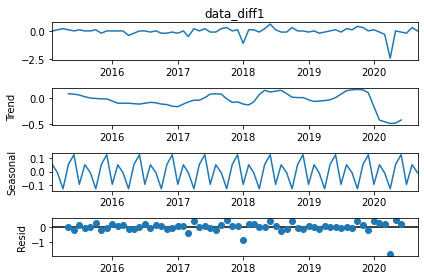

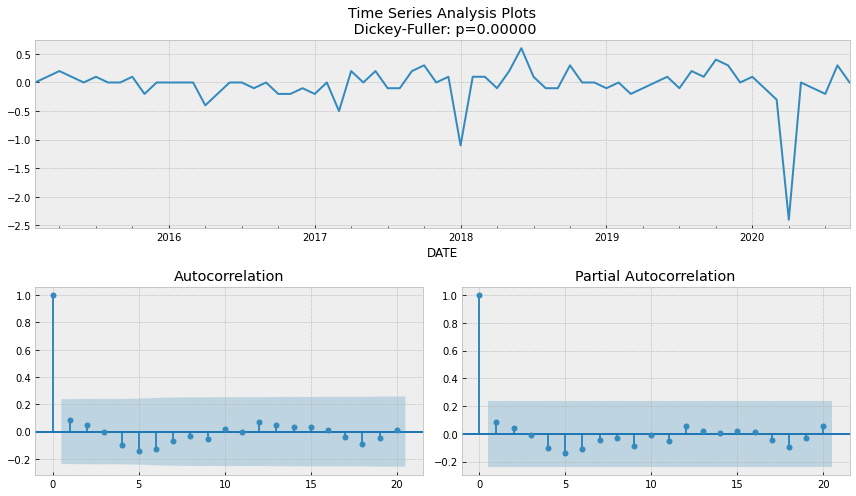

In [11]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
sm.tsa.seasonal_decompose(df['data_diff1'][1:],freq=6).plot()
plot_graphs(df.data_diff1[1:])

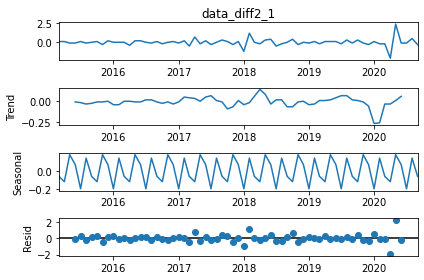

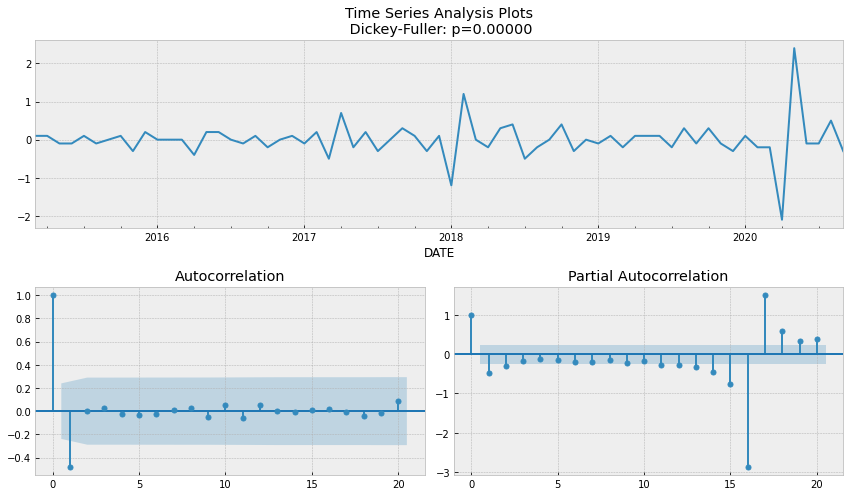

In [12]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
sm.tsa.seasonal_decompose(df['data_diff2_1'][2:],freq=6).plot()
plot_graphs(df.data_diff2_1[2:])

In [13]:
train_start =  0
train_end = len(df) - 6
train = df.iloc[train_start: train_end]

test_start = len(train)
test_end = len(train) + 6
test = df.iloc[len(train):len(train)+ 6] # 6 months of test post training


train_test = pd.concat([train, test], axis=0) # develop the model to retrain using train and test as development sample

val_start = len(train) + len(test) 
val_end =  len(train) +   len(test) + 3
#val = df.iloc[len(train) + len(test): len(train) + len(test) + 3] # 3 months of validation post training+test 

#train_start , train_end , test_start, test_end, val_start, val_end 
len(df), len(train), len(test), len(train_test)
#len(val), 


(69, 63, 6, 69)

In [14]:
# diagnostics show second difference is over differencing and canbe ignored

# Grid Search for choosing orders of best SARIMA Model

Iteration and reslts

In [15]:
# # Grid search SARIMAX
# #  Grid Search
# import itertools
# #set parameter range
# p = range(0,4)
# q = range(0,4)
# d = [1]
# D = [0,1,2]
# s = [0,5]
# Final_1 = pd.DataFrame(columns= ['Order', 'Seasonal_Order', 'MSE','MAPE', 'AIC'])
# dat = pd.DataFrame()
# # list of all parameter combos
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = list(itertools.product(p, D, q, s))
# # SARIMA model pipeline
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             order=[]
#             seasonal_order=[]
#             #Errors=[]
#             AIC=[]
#             mod = sm.tsa.statespace.SARIMAX(train.data,enforce_stationarity=True,
#                                     order=param,seasonal_order=param_seasonal)
#             results = mod.fit()
            
#             predictions = results.predict(start=test_start, end=test_end-1,  dynamic=False, typ='levels').rename('forecast')
#             test_pred = predictions.to_frame()
#             test1 = pd.merge(test, test_pred, how = 'outer',left_index=True, right_index=True) 
                      
            
#             from sklearn.metrics import mean_squared_error
#             #print(test1[['data','forecast']].head(2))
                       
#             MSE = metrics.mean_squared_error(test1.data, test1.forecast)
#             def mean_absolute_percentage_error(y_true, y_pred):
#                y_true, y_pred = np.array(y_true), np.array(y_pred)
#                return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
#             MAPE = mean_absolute_percentage_error(test1.data, test1.forecast)
            
#             print('SARIMA{},{} - AIC:{}, Test MAPE:{}'.format(param, param_seasonal, results.aic.round(), MAPE.round()))
#             cols = ['Order', 'Seasonal_Order', 'MSE','MAPE', 'AIC']
#             dat = pd.DataFrame(columns = cols)
#             dat = dat.append({'Order': param, 'Seasonal_Order':param_seasonal,'MSE': MSE,'MAPE':MAPE,'AIC':results.aic},ignore_index=True)

#             Final_1= Final_1.append(dat)
#             #print("Dataframe : " , dat, sep='\n')
#         except:
#             print("Code didnt run")
#             continue


In [16]:
# Final_1.to_excel('SARIMA_Gridshearch_All_emp_mfg_dur_gds_SA_MSA_M_Fred.xlsx', index = False, header=True)

# Final Chosen Orders based on the iteration with lowest AIC and MAPE combination

In [17]:
param = (0, 2, 3)
param_seasonal =  (2, 2, 1, 12)
# Order	Seasonal_Order	MSE	MAPE	AIC
# (0, 2, 3)	(2, 2, 1, 12)	25280879.69	0.571123387	690.2663785
# (3, 2, 2)	(1, 2, 1, 12)	25466472.59	0.573796102	689.9009869
# (1, 2, 3)	(2, 2, 1, 12)	23329646.05	0.57615676	690.9488732
# (0, 2, 3)	(1, 2, 2, 12)	25699966	0.580358145	690.2559599






# Running the best SARIMA Model post grid search on train

In [18]:


# fit ARIMA monthly based on helper plots
model2 = sm.tsa.statespace.SARIMAX(train.data, enforce_stationarity= True,
                                    order=param,seasonal_order=param_seasonal).fit()
print(model2.summary())
# Obtain predicted values

predictions = model2.predict(start=test_start, end=test_end-1, dynamic=False, typ='levels').rename('forecast')
test_pred = predictions.to_frame()
test1 = pd.merge(test, test_pred, how = 'outer',left_index=True, right_index=True) 
print("MAPE: ",get_mape(test1.data, test1.forecast))    
print("MSE: ", mean_squared_error(test1.data, test1.forecast))
print("MAE: ", mean_absolute_error(test1.data, test1.forecast))

                                      SARIMAX Results                                       
Dep. Variable:                                 data   No. Observations:                   63
Model:             SARIMAX(0, 2, 3)x(2, 2, [1], 12)   Log Likelihood                 -21.390
Date:                              Thu, 03 Dec 2020   AIC                             56.781
Time:                                      06:34:05   BIC                             68.057
Sample:                                  01-01-2015   HQIC                            60.756
                                       - 03-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0512     17.219     -0.061      0.951     -34.800      32.698
ma.L2         -0.16

In [19]:
# Retraining and FItting the Final Model on Validation set

In [20]:
# fit ARIMA monthly based on helper plots
model1_val = sm.tsa.statespace.SARIMAX(train_test.data,
                                    order=param,seasonal_order=param_seasonal).fit()
#print(model1_val.summary())
# Obtain predicted values

predictions_val = model1_val.predict(start=val_start, end=val_start+5, dynamic=False, typ='levels').rename('forecast')
val_pred = predictions_val.to_frame()
val_pred.round(2)
#val1 = pd.merge(val, val_pred, how = 'outer',left_index=True, right_index=True) 
#print("MAPE: ", get_mape(val1.data, val1.forecast))    
#print("MSE: ",  mean_squared_error(val1.data, val1.forecast))
#print("MAE: ",  mean_absolute_error(val1.data, val1.forecast))

,forecast
2020-10-01,21.50
2020-11-01,21.77
2020-12-01,21.42
2021-01-01,22.73
2021-02-01,22.27
2021-03-01,20.97


In [21]:
All_emp_mfg_dur_gds_SA_MSA_M_Fred = val_pred 
All_emp_mfg_dur_gds_SA_MSA_M_Fred

,forecast
2020-10-01,21.497135
2020-11-01,21.771505
2020-12-01,21.419246
2021-01-01,22.731341
2021-02-01,22.270412
2021-03-01,20.968040


In [22]:
All_emp_mfg_dur_gds_SA_MSA_M_Fred_1 = train_test.append(All_emp_mfg_dur_gds_SA_MSA_M_Fred.rename(columns={'forecast':'data'}))
All_emp_mfg_dur_gds_SA_MSA_M_Fred_1

,data,data_diff1,data_diff2_1
2015-01-01,24.400000,NaN,NaN
2015-02-01,24.400000,0.0,NaN
2015-03-01,24.500000,0.1,0.1
2015-04-01,24.700000,0.2,0.1
2015-05-01,24.800000,0.1,-0.1
...,...,...,...
2020-11-01,21.771505,NaN,NaN
2020-12-01,21.419246,NaN,NaN
2021-01-01,22.731341,NaN,NaN
2021-02-01,22.270412,NaN,NaN


In [23]:
# Obtain predicted values on train data
start=1
end=len(train)+len(test)-1
predictions_train = model2.predict(start=train_start, end=train_end-1, dynamic=False, typ='levels').rename('forecast')
predictions_train
train_pred = predictions_train.to_frame()
train1 = pd.merge(train, train_pred, how = 'left',left_index=True, right_index=True)
train1 = train1.iloc[1:]
#train1[['data','forecast']].head(10)

# Test and Validation Actuals vs Forecasts

In [24]:
print("  ")
print("Test Dataset actuals and Forecasts")
test1[['data','forecast']].round(0)

  
Test Dataset actuals and Forecasts


,data,forecast
DATE,,
2020-04-01,22.0,25.0
2020-05-01,22.0,25.0
2020-06-01,22.0,25.0
2020-07-01,21.0,25.0
2020-08-01,22.0,26.0
2020-09-01,22.0,26.0


In [25]:
# print("  ")
# print("Validation Dataset actuals and Forecasts")
# val1[['data','forecast']].round(0)

# Model Evaluation Metrics

In [26]:
# test metrics
print("Model Evaluation Metrics")   
print(" ")      

print("Test Model AIC : ", model2.aic.round(1))      
print("Test Model  : ", model2.bic.round(1))    
print(" ") 

print("Test MSE: ", mean_squared_error(test1.data, test1.forecast),        "             Train MSE: ", mean_squared_error(train1.data, train1.forecast))
print("Test MAE: ", mean_absolute_error(test1.data, test1.forecast),       "            Train MAE: ", mean_absolute_error(train1.data, train1.forecast))
print("Test RMSE: ", get_rmse(test1.data, test1.forecast),                 "           Train RMSE: ", get_rmse(train1.data, train1.forecast))
print("Test MAPE: ", get_mape(test1.data, test1.forecast),                 "           Train MAPE: ", get_mape(train1.data, train1.forecast))
print("Test MASE: ", get_mase(test1.data, test1.forecast),                 "           Train MASE: ", get_mase(train1.data, train1.forecast))

Model Evaluation Metrics
 
Test Model AIC :  56.8
Test Model  :  68.1
 
Test MSE:  14.171773831139214              Train MSE:  12.55400795037955
Test MAE:  3.740834151304549             Train MAE:  1.0892689531840654
Test RMSE:  3.7645416495423736            Train RMSE:  3.543163551175636
Test MAPE:  17.374637767826755            Train MAPE:  4.482363624973198
Test MASE:  0.964185689608201            Train MASE:  1.3495652217410998


# Graphical representation

Actual (in Blue) Vs forecast (in Orange)

           Train (Jan 16 - June 19)                  Test(July 19 - Mar 20)            


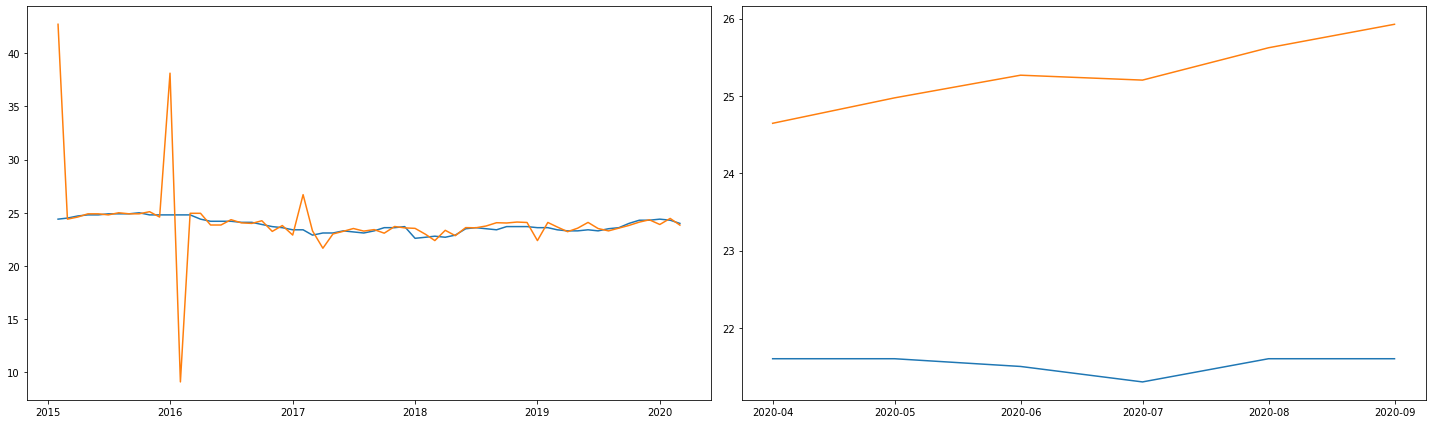

In [27]:
print("Actual (in Blue) Vs forecast (in Orange)")
print("")
print("           Train (Jan 16 - June 19)                  Test(July 19 - Mar 20)            ")
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d')

x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)
y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
axes[0].plot(train1[['data','forecast']])
axes[1].plot(test1[['data','forecast']])
#axes[2].plot(val1[['data','forecast']])
fig.tight_layout()

In [28]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

# Model Diagnostics on residuals

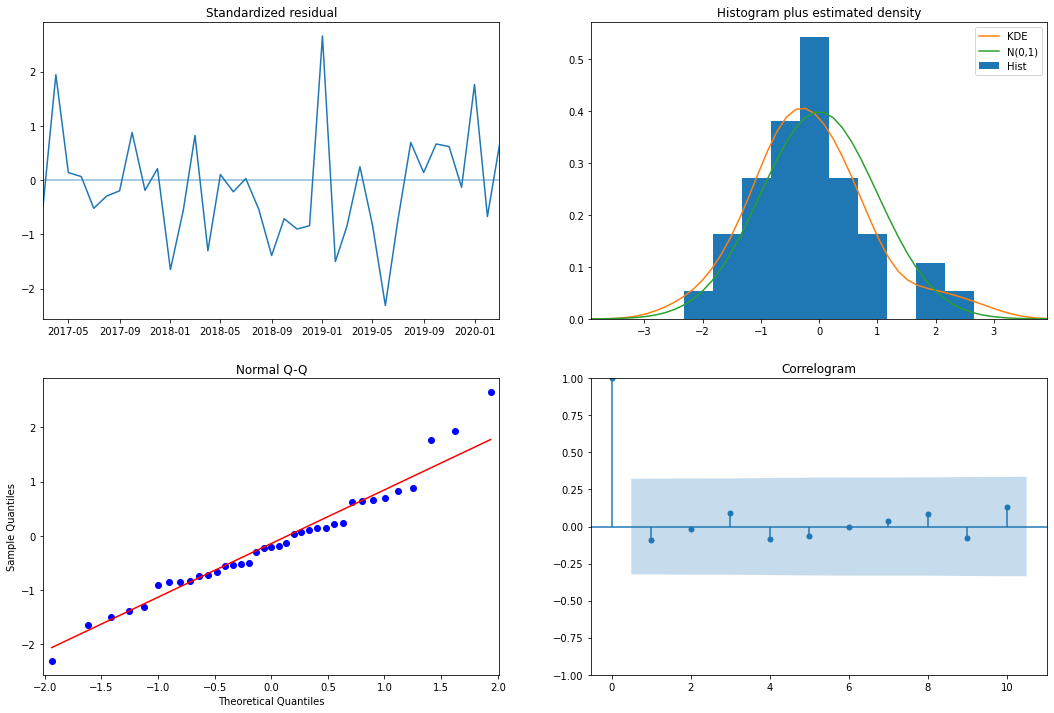

In [29]:
# plot residual diagnostics
model2.plot_diagnostics(figsize=(18, 12));

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the SARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). However we also we see the high variance towards the start and end of the graph suggesting possible further improvement

The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

# ACF and PACF on residuals 

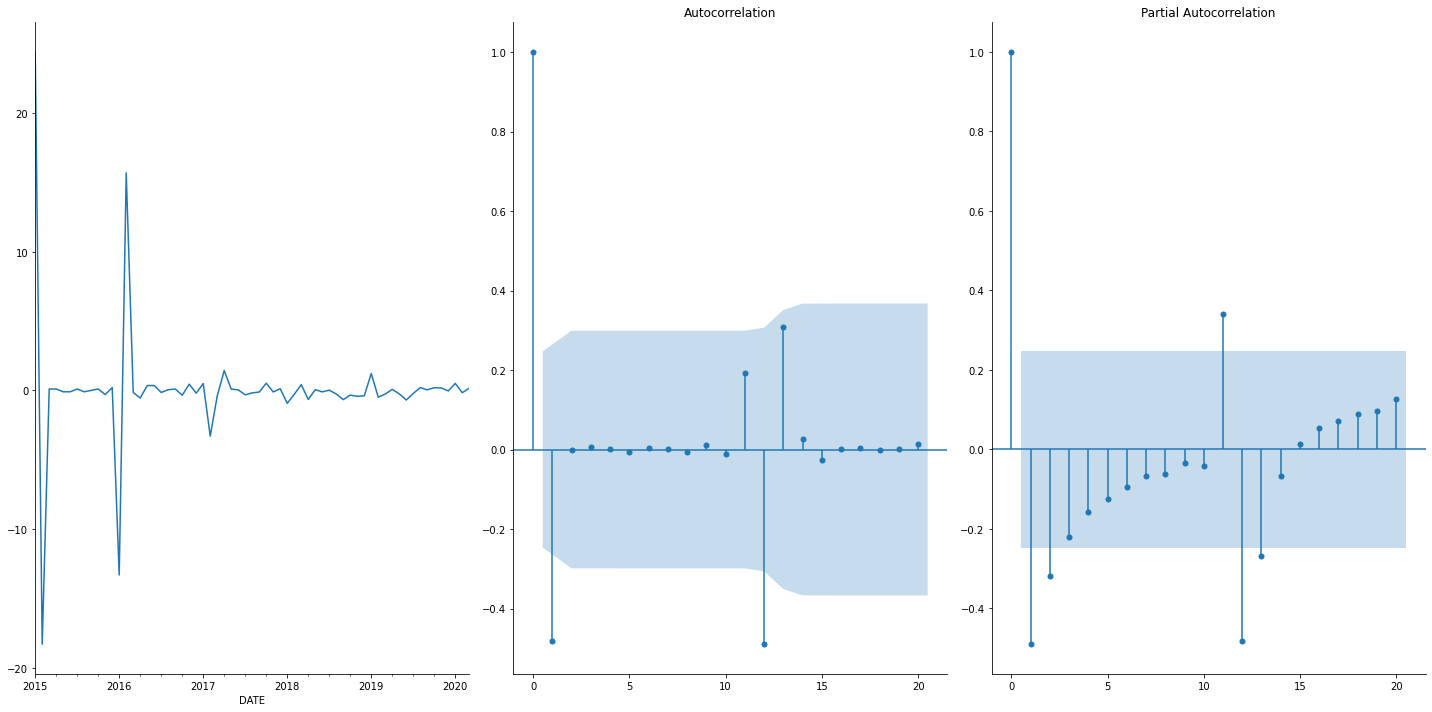

In [30]:
# plot resids
plt.figure(figsize=(20,10))
plots(model2.resid, lags=20);